Lightly edited for clarity as Noah goes through this...

# Compartmental Models

In [2]:
# Adapted from https://pyro.ai/examples/sir_hmc.html by Swapneel and Noah

In [11]:
import argparse
import logging
import math
import re
from collections import OrderedDict

import torch
from torch import distributions as tdist
from pyro import distributions as dist

from matplotlib import pyplot as plt
import seaborn as sns
import logging

import pyro.distributions as dist
import pyro.distributions.hmm
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, config_enumerate, infer_discrete
from pyro.infer.autoguide import init_to_value
from pyro.ops.special import safe_log
from pyro.ops.tensor_utils import convolve
from pyro.util import warn_if_nan
plt.style.use('dark_background')

logging.basicConfig(format='%(message)s', level=logging.INFO)


# still can't figure out exactly what $\rho$ represents in the global population parameters for COVID-19
# we noisily observe the number of people *newly infected* at each time step, 
# assuming an unknown false negative rate but NO FALSE POSITIVES (implying the COVID test cares about Type II errors over Type I)!
 (Pretty easy to argue this is true.)
# $\rho$ is then the mean response rate which is 1 - false negative rate

# $\rho$ is used as a parameter when sampling from the extended binomial such that a person goes from Susceptible 
# to Infected with a probability \rho so that means 1 - $\rho$ is the probability that a Susceptible person is 
# not actually infected which makes sense as that equals the false negative rate when testing a random sample of the population
# at any given time step.
# Ok I think I understand rho better now!

### 1. The Priors we place on R0 and $\rho$

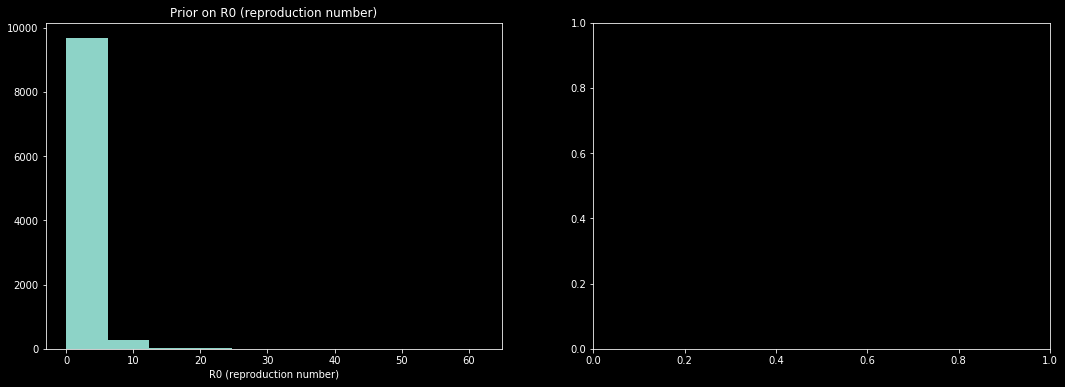

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

r0_dist = tdist.LogNormal(0., 1.) # we form a prior distribution on r0 that it's a lognormal dist. 
r0_samples = r0_dist.sample(torch.Size([10000]))

ax[0].hist(r0_samples)
#sns.hist(r0_samples, ax=ax[0])
ax[0].set_xlabel('R0 (reproduction number)')
ax[0].set_title('Prior on R0 (reproduction number)')

#sns.hist
plt.show()

In [17]:
def global_model(population):
    """
    From the population and initial values for recovery time, R0, and rho, convert interpretable values
    
    (an epidemiologist knows what R0 is but not rate_s), into the parameters needed for the distribution. 
    
    
    Returns
    -------
    
    rate_s: rate of infection i 
    
    prob_i: probality of infection? 
    
    rho: not sure yet. 
    """
    tau = args.recovery_time  # Assume this can be measured exactly... TODO: Why not make this also a dist? 
    R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
    rho = pyro.sample("rho", dist.Uniform(0, 1))

    # Convert interpretable parameters to distribution parameters.
    rate_s = -R0 / (tau * population)
    prob_i = 1 / (1 + tau)

    return rate_s, prob_i, rho


def discrete_model(args, data):
    """
    create discrete model 
    """
    # Sample global parameters.
    rate_s, prob_i, rho = global_model(args.population)

    # Sequentially sample time-local variables.
    S = torch.tensor(args.population - 1.)
    I = torch.tensor(1.)
    for t, datum in enumerate(data): # for data point in dataset, use this distribution to  
        S2I = pyro.sample("S2I_{}".format(t),
                          dist.Binomial(S, -(rate_s * I).expm1()))
        I2R = pyro.sample("I2R_{}".format(t),
                          dist.Binomial(I, prob_i))
        S = pyro.deterministic("S_{}".format(t), S - S2I) 
        I = pyro.deterministic("I_{}".format(t), I + S2I - I2R) # the diff eqs
        pyro.sample("obs_{}".format(t),
                    dist.ExtendedBinomial(S2I, rho),
                    obs=datum)

In [49]:
# We can use this model to simulate data. We'll use poutine.condition to pin
# parameter values and poutine.trace to record sample observations.

def generate_data(args):
    """
    Simulate data. 
    
    Using args to input initial estimates on R0 and other epidemiology jargon, return a list of the compartment populations
    according to these conditions. 
    
    S2I, I2R
    """
    logging.info("Generating data...")
    params = {"R0": torch.tensor(args.basic_reproduction_number),
              "rho": torch.tensor(args.response_rate)}
    empty_data = [None] * (args.duration + args.forecast)

    # We'll retry until we get an actual outbreak.
    for attempt in range(100):
        with poutine.trace() as tr:
            with poutine.condition(data=params):
                discrete_model(args, empty_data)

        # Concatenate sequential time series into tensors.
        obs = torch.stack([site["value"]
                           for name, site in tr.trace.nodes.items()
                           if re.match("obs_[0-9]+", name)])
        S2I = torch.stack([site["value"]
                          for name, site in tr.trace.nodes.items()
                          if re.match("S2I_[0-9]+", name)])
    
        I2R = torch.stack([site["value"]
                          for name, site in tr.trace.nodes.items()
                          if re.match("I2R_[0-9]+", name)])
        
        
        
        assert len(obs) == len(empty_data)

        obs_sum = int(obs[:args.duration].sum())
        S2I_sum = int(S2I[:args.duration].sum())
        I2R_sum = int(I2R[:args.duration].sum())
        if obs_sum >= args.min_observations:
            logging.info("Observed {:d}/{:d} infections:\n{}".format(
                obs_sum, S2I_sum, I2R_sum, " ".join([str(int(x)) for x in obs[:args.duration]])))
            return {"S2I": S2I, "obs": obs, "I2R": I2R}

    raise ValueError("Failed to generate {} observations. Try increasing "
                     "--population or decreasing --min-observations"
                     .format(args.min_observations))



In [50]:
from argparse import Namespace
args = Namespace(population=1000000, 
                 min_observations=3, 
                 duration=100, 
                 forecast=0, 
                 basic_reproduction_number=1.5, 
                 recovery_time=7.0, 
                 response_rate=0.5, 
                 enum=True, 
                 sequential=True, 
                 num_samples=2000, 
                 warmup_steps=100, 
                 max_tree_depth=5, 
                 rng_seed=0, 
                 double=True, 
                 jit=True, 
                 cuda=True, 
                 verbose=True, 
                 plot=True)

In [51]:
x = generate_data(args)
x

Generating data...
Observed 31219/62615 infections:
37907


{'S2I': tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         2.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00, 3.0000e+00, 7.0000e+00,
         5.0000e+00, 8.0000e+00, 7.0000e+00, 5.0000e+00, 5.0000e+00, 8.0000e+00,
         7.0000e+00, 1.3000e+01, 1.0000e+01, 7.0000e+00, 7.0000e+00, 9.0000e+00,
         1.5000e+01, 1.8000e+01, 2.1000e+01, 1.4000e+01, 3.0000e+01, 2.6000e+01,
         2.5000e+01, 2.9000e+01, 2.9000e+01, 3.2000e+01, 4.0000e+01, 4.0000e+01,
         3.9000e+01, 4.3000e+01, 5.5000e+01, 5.3000e+01, 7.5000e+01, 8.2000e+01,
         7.2000e+01, 7.7000e+01, 8.5000e+01, 8.1000e+01, 1.1300e+02, 1.1300e+02,
         1.1500e+02, 1.5000e+02, 1.7000e+02, 1.7100e+02, 1.9400e+02, 1.9300e+02,
         2.1000e+02, 2.2900e+02, 2.5500e+02, 2.6800e+02, 2.9600e+02, 3.2200e+02,
         3.5400e+02, 3.6900e+02, 4.3200e+02, 4.3900e+02, 5.1400e+02, 5.1300e+02,
         5.7600e+02, 

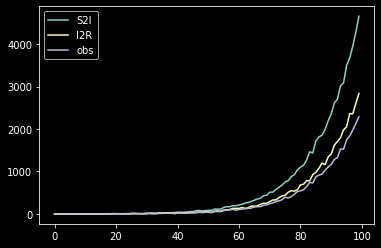

In [52]:
plt.plot(x['S2I'],label='S2I')
plt.plot(x['I2R'],label='I2R')
plt.plot(x['obs'],label='obs')
plt.legend()

In [47]:
# Inference
# =========
#
# While the above discrete_model is easy to understand, its discrete latent
# variables pose a challenge for inference. One of the most popular inference
# strategies for such models is Sequential Monte Carlo. However since Pyro and
# PyTorch are stronger in gradient based vectorizable inference algorithms, we
# will instead pursue inference based on Hamiltonian Monte Carlo (HMC).
#
# Our general inference strategy will be to:
# 1. Introduce auxiliary variables to make the model Markov.
# 2. Introduce more auxiliary variables to create a discrete parameterization.
# 3. Marginalize out all remaining discrete latent variables.
# 4. Vectorize to enable parallel-scan temporal filtering.
#
# Let's consider reparameterizing in terms of the variables (S, I) rather than
# (S2I, I2R). Since these may lead to inconsistent states, we need to replace
# the Binomial transition factors (S2I, I2R) with ExtendedBinomial.
#
# The following model is equivalent to the discrete_model:

@config_enumerate
def reparameterized_discrete_model(args, data):
    # Sample global parameters.
    rate_s, prob_i, rho = global_model(args.population)

    # Sequentially sample time-local variables.
    S_curr = torch.tensor(args.population - 1.)
    I_curr = torch.tensor(1.)
    for t, datum in enumerate(data):
        # Sample reparameterizing variables.
        # When reparameterizing to a factor graph, we ignored density via
        # .mask(False). Thus distributions are used only for initialization.
        S_prev, I_prev = S_curr, I_curr
        S_curr = pyro.sample("S_{}".format(t),
                             dist.Binomial(args.population, 0.5).mask(False))
        I_curr = pyro.sample("I_{}".format(t),
                             dist.Binomial(args.population, 0.5).mask(False))

        # Now we reverse the computation.
        S2I = S_prev - S_curr
        I2R = I_prev - I_curr + S2I
        pyro.sample("S2I_{}".format(t),
                    dist.ExtendedBinomial(S_prev, -(rate_s * I_prev).expm1()),
                    obs=S2I)
        pyro.sample("I2R_{}".format(t),
                    dist.ExtendedBinomial(I_prev, prob_i),
                    obs=I2R)
        pyro.sample("obs_{}".format(t),
                    dist.ExtendedBinomial(S2I, rho),
                    obs=datum)

